### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm # For colors in scatterplots
import seaborn as sns # For plotting
import warnings # Ignore Warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_regression # To create synthetic dataset 
from sklearn.datasets import fetch_california_housing # To import california_housing dataset
from xgboost import XGBClassifier # XG Boost Model
from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.model_selection import train_test_split # Split into train and test
from sklearn.neighbors import KNeighborsRegressor # For K Neighbors
from sklearn.neighbors import KNeighborsClassifier # For K Neighbors
from sklearn.metrics import r2_score # R^2
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn import preprocessing # Label encoder
from sklearn.preprocessing import OneHotEncoder # One Hot Encoder

# Set scale of the scatter plots
SPLOTSCALE = .8

# Set scale of outlier plots
PLOTSCALE = .4

# Sets the random state (seed) so results can be replicated
RANDOM_STATE=7

# K Neighbours - # of neighbors
KREG = 3
KCLASS = 2

# Names of each Model
NAMES = ['Linear Regression',
         'Logistic Regression',
         'XGBoost Regressor',
         'K Neighbor Regressor',
         'K Neighbor Classifier']

# Code for each Model
MODELS = [LinearRegression(),
          LogisticRegression(solver='liblinear'),
          XGBClassifier(eval_metric='mlogloss'),
          KNeighborsRegressor(n_neighbors=KREG),
          KNeighborsClassifier(n_neighbors=KCLASS)]

### Scatterplot Function

In [ ]:
XList = {}
for i in range(6):
    XList[i-1] = 'Feature %s' % i

def scatterPlot(title="Title",plotType=""):
    # Synthetic Plot Features
    if plotType == 's':
        colors = iter(cm.rainbow(np.linspace(0, 1, len(XList)))) # For the color of the each Feature in scatterplot
        f, ax = plt.subplots(3, 2, figsize=(12*SPLOTSCALE, 15*SPLOTSCALE))
        f.suptitle(title, fontsize=16), f.delaxes(ax[2,1]) # Removing index in pos 2,1
        
        a=[0,0,1,1,2] # For the 'y' positions
        b=[0,1,0,1,0] # For the 'x' positions
        n = 5
        labels = XList
    
    # Housing Plot Features
    else:
        colors = iter(cm.rainbow(np.linspace(0, 1, len(housing.feature_names)))) # For the color of the each Feature in scatterplot
        f, ax = plt.subplots(4, 2, figsize=(12*SPLOTSCALE, 15*SPLOTSCALE))
        f.suptitle(title, fontsize=16)

        a=[0,0,1,1,2,2,3,3] # For the 'y' positions
        b=[0,1,0,1,0,1,0,1] # For the 'x' positions
        n = 8
        labels = housing.feature_names

    # Code to plot
    for i in range(0,n):
        plt.sca(ax[a[i], b[i]])
        plt.scatter(X[:,i], y, color=next(colors), marker='.', label=labels[i]) # 'next()' gets the next iteration
        plt.xlabel(labels[i])
        if b[i] == 0:
            plt.ylabel('y axis')
        plt.legend(loc='upper right')

### Outliers Function

In [ ]:
def comparePlot(df,dfnew,feature,title,type1='capping'):
    # compare the distribution after capping/trimming
    print(title + ': Comparing the distribution of',feature, 'after', type1)
    plt.figure(figsize=(12*PLOTSCALE,6*PLOTSCALE))
    plt.subplot(2,2,1)
    sns.distplot(df[feature])
    plt.subplot(2,2,2)
    sns.boxplot(df[feature])
    plt.subplot(2,2,3)
    sns.distplot(dfnew[feature])
    plt.subplot(2,2,4)
    sns.boxplot(dfnew[feature])
    plt.show()


def outliers(feature,df,df_z,df_iqr,df_per,df_win):
    # Z-score

    # finding the boundary values
    threshold = 10 # Was 3
    HA = df_z['y'].mean() + threshold*df_z['y'].std()
    LA = df_z['y'].mean() - threshold*df_z['y'].std()

    # trimming of Outliers
    df_z = df_z[(df_z['y'] < HA) & (df_z['y'] > LA)]
    df_z.head()

    # capping on Outliers
    UL = df_z['y'].mean() + threshold*df_z['y'].std()
    LL = df_z['y'].mean() - threshold*df_z['y'].std()

    # apply the capping
    df_z['y'] = np.where(
        df_z['y']>UL, UL,
        np.where(
            df_z['y']<LL, LL,
            df_z['y']
        )
    )

    #-------------------------------------------------------------------------
    # IQR based filtering
    
    # finding the IQR
    Q1 = df_iqr[feature].quantile(0.25)
    Q3 = df_iqr[feature].quantile(0.75)
    IQR = Q3 - Q1

    # finding upper and lower limit
    # 1.5 is the general consensis
    UL2 = Q3 + 1.5 * IQR
    LL2 = Q1 - 1.5 * IQR

    # finding Outliers
    df_iqr[df_iqr[feature] > UL2]
    df_iqr[df_iqr[feature] < LL2]

    # trimming
    new_df_iqr = df_iqr[df_iqr[feature] < UL2]
    new_df_iqr.shape

    # capping
    new_df_cap = df_iqr.copy()
    new_df_cap[feature] = np.where(
        new_df_cap[feature] > UL2, UL2,
        np.where(
            new_df_cap[feature] < LL2, LL2,
            new_df_cap[feature]
        )
    )
    df_iqr = new_df_iqr
    
    #-------------------------------------------------------------------------
    # Percentile

    # upper and lower limit
    # can play with the parameters
    UL3 = df_per[feature].quantile(0.90)
    LL3 = df_per[feature].quantile(0.10)

    # apply trimming
    new_df_per = df_per[(df_per[feature] <= UL3) & (df[feature] >= LL3)]
    df_per = new_df_per

    #-------------------------------------------------------------------------
    # Winsorization
    # apply capping (Winsorization)
    df_win[feature] = np.where(df_win[feature] >= UL3, UL3,
            np.where(df_win[feature] <= LL3, LL3,
            df_win[feature]))

    return df_z, df_iqr, df_per, df_win

### Function to print model results

In [ ]:
def print_results(input_model, model_name, XTrain, yTrain, XTest, yTest,
                                           XTrainZ, yTrainZ, XTestZ, yTestZ,
                                           XTrainIQR, yTrainIQR, XTestIQR, yTestIQR,
                                           XTrainPER, yTrainPER, XTestPER, yTestPER,
                                           XTrainWIN, yTrainWIN, XTestWIN, yTestWIN):
    # Creating the model
    model = z_model = iqr_model = per_model = win_model = input_model

    # Fitting the model to the data
    model.fit(XTrain, yTrain)
    z_model.fit(XTrainZ, yTrainZ)
    iqr_model.fit(XTrainIQR, yTrainIQR)
    per_model.fit(XTrainPER, yTrainPER)
    win_model.fit(XTrainWIN, yTrainWIN)

    # Make predictions (assign class labels)
    y_pred = model.predict(XTest)
    y_predZ = z_model.predict(XTestZ)
    y_predIQR = iqr_model.predict(XTestIQR)
    y_predPER = per_model.predict(XTestPER)
    y_predWIN = win_model.predict(XTestWIN)
    
    # Dataframe for Scores
    if model_name != 'Linear Regression' and model_name != 'K Neighbor Regressor':
      df_scores = pd.DataFrame({'Score': ['Training Accuracy',
                                          'Test Accuracy',
                                          'R\u00b2',
                                          'Accuracy',
                                          'Weighted F1',
                                          'Weighted Precision',
                                          'Weighted Recall'],
                                
                                'Train/Test': [model.score(XTrain, yTrain),
                                               model.score(XTest, yTest),
                                               r2_score(yTest, y_pred),
                                               accuracy_score(yTest, y_pred),
                                               f1_score(yTest, y_pred, average='weighted'),
                                               precision_score(yTest, y_pred, average='weighted'),
                                               recall_score(yTest, y_pred, average='weighted')],
                                
                                'Z-Score': [z_model.score(XTrainZ, yTrainZ),
                                            z_model.score(XTestZ, yTestZ),
                                            r2_score(yTestZ, y_predZ),
                                            accuracy_score(yTestZ, y_predZ),
                                            f1_score(yTestZ, y_predZ, average='weighted'),
                                            precision_score(yTestZ, y_predZ, average='weighted'),
                                            recall_score(yTestZ, y_predZ, average='weighted')],
                                
                                'IQR': [iqr_model.score(XTrainIQR, yTrainIQR),
                                        iqr_model.score(XTestIQR, yTestIQR),
                                        r2_score(yTestIQR, y_predIQR),
                                        accuracy_score(yTestIQR, y_predIQR),
                                        f1_score(yTestIQR, y_predIQR, average='weighted'),
                                        precision_score(yTestIQR, y_predIQR, average='weighted'),
                                        recall_score(yTestIQR, y_predIQR, average='weighted')],
                                
                                'Percentile': [per_model.score(XTrainPER, yTrainPER),
                                               per_model.score(XTestPER, yTestPER),
                                               r2_score(yTestPER, y_predPER),
                                               accuracy_score(yTestPER, y_predPER),
                                               f1_score(yTestPER, y_predPER, average='weighted'),
                                               precision_score(yTestPER, y_predPER, average='weighted'),
                                               recall_score(yTestPER, y_predPER, average='weighted')],
                                
                                'Winsorization': [win_model.score(XTrainWIN, yTrainWIN),
                                                  win_model.score(XTestWIN, yTestWIN),
                                                  r2_score(yTestWIN, y_predWIN),
                                                  accuracy_score(yTestWIN, y_predWIN),
                                                  f1_score(yTestWIN, y_predWIN, average='weighted'),
                                                  precision_score(yTestWIN, y_predWIN, average='weighted'),
                                                  recall_score(yTestWIN, y_predWIN, average='weighted')]}).round(2) # Rounds values to 2 decimal places
    else:
      df_scores = pd.DataFrame({'Score': ['Training Accuracy',
                                          'Test Accuracy',
                                          'R\u00b2'],
                                
                                'Train/Test': [model.score(XTrain, yTrain),
                                               model.score(XTest, yTest),
                                               r2_score(yTest, y_pred)],
                                
                                'Z-Score': [z_model.score(XTrainZ, yTrainZ),
                                            z_model.score(XTestZ, yTestZ),
                                            r2_score(yTestZ, y_predZ)],
                                
                                'IQR': [iqr_model.score(XTrainIQR, yTrainIQR),
                                        iqr_model.score(XTestIQR, yTestIQR),
                                        r2_score(yTestIQR, y_predIQR)],
                                
                                'Percentile': [per_model.score(XTrainPER, yTrainPER),
                                               per_model.score(XTestPER, yTestPER),
                                               r2_score(yTestPER, y_predPER)],
                                
                                'Winsorization': [win_model.score(XTrainWIN, yTrainWIN),
                                                  win_model.score(XTestWIN, yTestWIN),
                                                  r2_score(yTestWIN, y_predWIN)]}).round(2) # Rounds values to 2 decimal places
                          
    return df_scores

### K Classifier Plot

In [ ]:
def kClassPlot(XTrain, yTrain, XTest, yTest,
               XTrainZ, yTrainZ, XTestZ, yTestZ,
               XTrainIQR, yTrainIQR, XTestIQR, yTestIQR,
               XTrainPER, yTrainPER, XTestPER, yTestPER,
               XTrainWIN, yTrainWIN, XTestWIN, yTestWIN):

    techniqueName = ['Train/Test','Z-Score','IQR','Percentile','Winsorization']
    techniqueName = [i + " # of neighbors" for i in techniqueName]

    XTrainArray = [XTrain,XTrainZ,XTrainIQR,XTrainPER,XTrainWIN]
    XTestArray = [XTest,XTestZ,XTestIQR,XTestPER,XTestWIN]
    yTrainArray = [yTrain,yTrainZ,yTrainIQR,yTrainPER,yTrainWIN]
    yTestArray = [yTest,yTestZ,yTestIQR,yTestPER,yTestWIN]

    colors = iter(cm.rainbow(np.linspace(0, 1, 10))) # For the color of the each Feature in scatterplot
    f, ax = plt.subplots(3, 2, figsize=(12*SPLOTSCALE, 15*SPLOTSCALE))
    f.suptitle('K Classification Plots', fontsize=16), f.delaxes(ax[2,1]) # Removing index in pos 2,1
    
    a=[0,0,1,1,2,2] # For the 'y' positions
    b=[0,1,0,1,0,1] # For the 'x' positions

    for i in range(5):
        plt.sca(ax[a[i], b[i]])
        training_accuracy = []
        test_accuracy = []
        # try n_neighbors from 1 to 10
        neighbors_settings = range(1, 11)

        for n_neighbors in neighbors_settings:
            # build the model
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(XTrainArray[i], yTrainArray[i])
            # record training set accuracy
            training_accuracy.append(knn.score(XTrainArray[i], yTrainArray[i]))
            # record test set accuracy
            test_accuracy.append(knn.score(XTestArray[i], yTestArray[i]))
        plt.plot(neighbors_settings, training_accuracy, label="Training accuracy", color=next(colors))
        plt.plot(neighbors_settings, test_accuracy, label="Test accuracy", color=next(colors))
        plt.ylabel("Accuracy"), plt.xlabel(techniqueName[i])
        plt.legend()

## Dataset 1: Synthetic

### 1.1 Creating the Dataset & Detecting NANs

Data has NANs: False


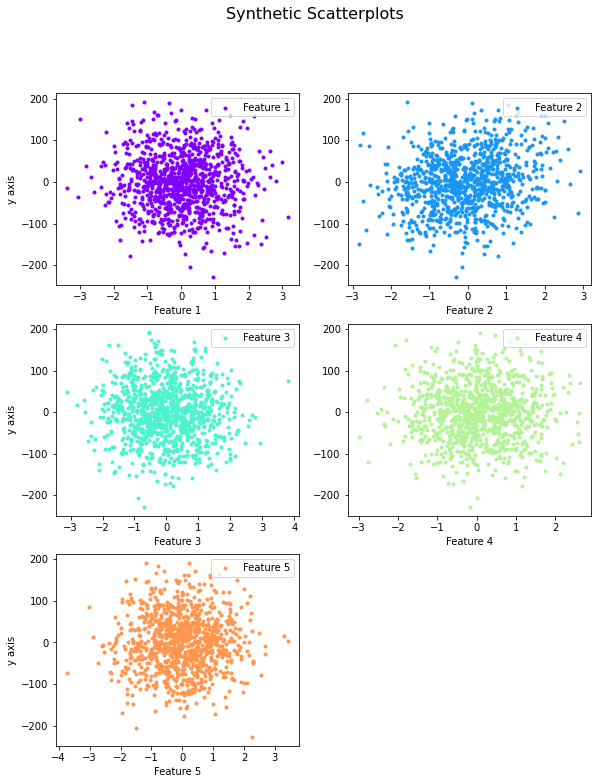

In [ ]:
n_samples = 1000
X, y = make_regression(n_samples=n_samples, 
                       n_features=5, 
                       n_informative=1, 
                       noise=65, 
                       random_state=0)

# Checking for NANs
print('Data has NANs:', np.isnan(np.sum(X)))

# Plotting
scatterPlot('Synthetic Scatterplots','s')

### 1.2 Adding Outliers

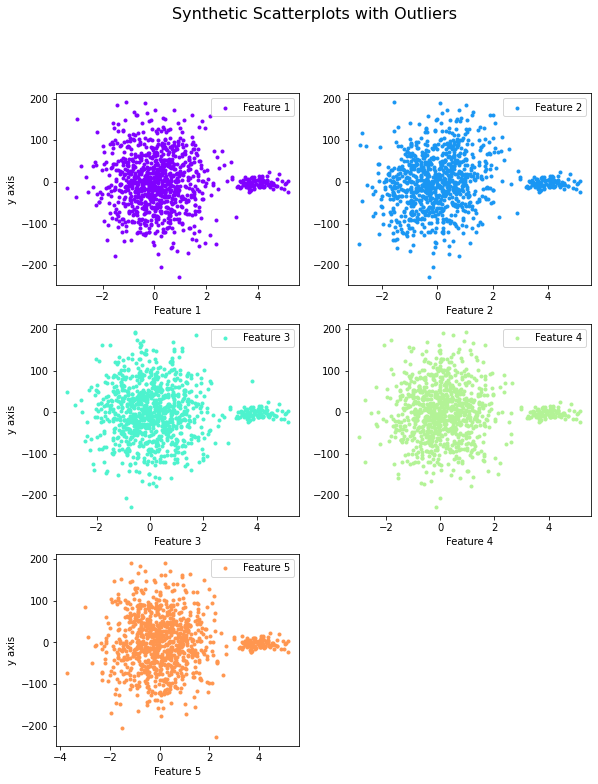

In [ ]:
n_outliers = int(np.round(n_samples*0.1))
th = 4
X[:n_outliers] = th + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -th + 10 * np.random.normal(size=n_outliers)


# Plotting
scatterPlot('Synthetic Scatterplots with Outliers','s')

### 1.3 Scaling the Data

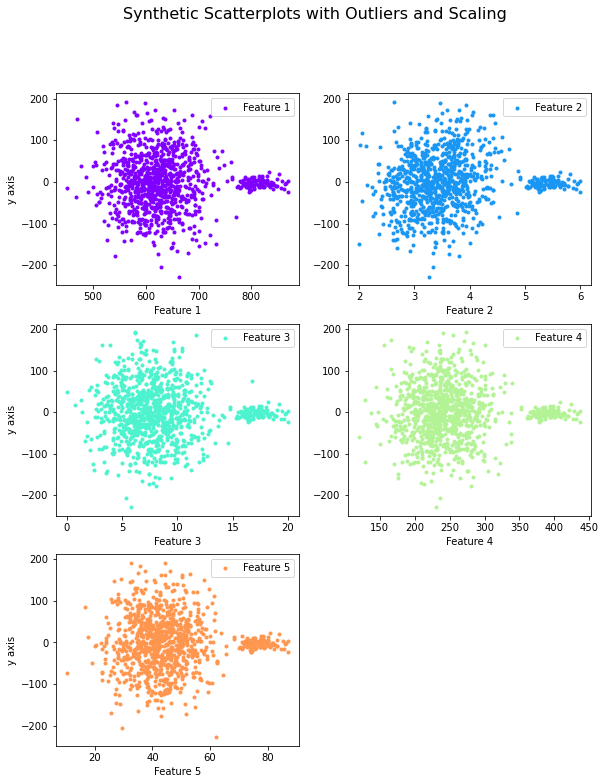

In [ ]:
# Scale Feature 1: 450-870 (float)
f1_l, f1_u = float(450), float(870)
X[:,0] = np.interp(X[:,0], (X[:,0].min(), X[:,0].max()), (f1_l, f1_u))

# Scale Feature 2: 2-6 (integer)
f2_l, f2_u = 2, 6
X[:,1] = np.interp(X[:,1], (X[:,1].min(), X[:,1].max()), (f2_l, f2_u))

# Scale Feature 3: 0-20 (integer)
f3_l, f3_u = 0, 20
X[:,2] = np.interp(X[:,2], (X[:,2].min(), X[:,2].max()), (f3_l, f3_u))

# Scale Feature 4: 120.56-436.92 (float)
f4_l, f4_u = float(120.56), float(436.92)
X[:,3] = np.interp(X[:,3], (X[:,3].min(), X[:,3].max()), (f4_l, f4_u))

# Scale Feature 5: 10.22-87.15 (float)
f5_l, f5_u = float(10.22), float(87.15)
X[:,4] = np.interp(X[:,4], (X[:,4].min(), X[:,4].max()), (f5_l, f5_u))

# Scale Output Var: 150000-2000000 (integer)
# Not sure about this??


# Plotting
scatterPlot('Synthetic Scatterplots with Outliers and Scaling','s')

### 1.4 Detect and Remove Outliers

Z-Score: Comparing the distribution of Feature 1 after capping


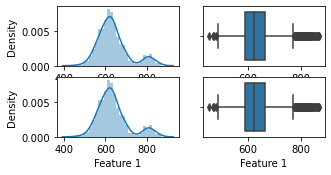

IQR Based Filtering: Comparing the distribution of Feature 1 after capping


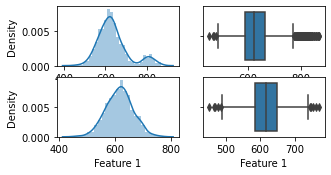

Percentile: Comparing the distribution of Feature 1 after trimming


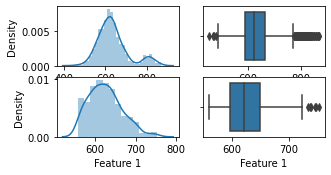

Winsorization: Comparing the distribution of Feature 1 after capping


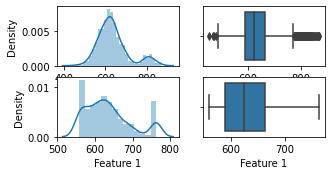

In [ ]:
# Converting y to multiclass (5 classes)
c1, c2, c3, c4 = np.percentile(y, [20, 40, 60, 80])
pos = 0
for i in y:
    if i < c1:
        y[pos] = 0
    elif i < c2:
        y[pos] = 1
    elif i < c3:
        y[pos] = 2
    elif i < c4:
        y[pos] = 3
    else:
        y[pos] = 4
    pos+=1

# Convert to DataFrame
df = pd.DataFrame({'Feature 1': X[:,0].flatten(),
                   'Feature 2': X[:,1].flatten(),
                   'Feature 3': X[:,2].flatten(),
                   'Feature 4': X[:,3].flatten(),
                   'Feature 5': X[:,4].flatten(),
                   'y': y})

# Initializing dfs
df_z = df_iqr = df_per = df_win = df.copy()
for i in range(0,5):
    df_z,df_iqr,df_per,df_win = outliers(df.columns[i], df, df_z,df_iqr,df_per,df_win)

# Plotting One Feature
DFLIST = [df_z,df_iqr,df_per,df_win]
DFNAMES = ['Z-Score','IQR Based Filtering','Percentile','Winsorization']
feature = 'Feature 1' 
for i,name in zip(DFLIST, DFNAMES):
    if name == 'Percentile':
        comparePlot(df,i,feature,name,type1='trimming')
    else:
        comparePlot(df,i,feature,name)

# Converting to numpy
df_z = df_z.to_numpy()
df_iqr = df_iqr.to_numpy()
df_per = df_per.to_numpy()
df_win = df_win.to_numpy()

### 1.5 Apply sampling strategies

In [ ]:
# Training: 70%, Test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainZ, XTestZ, yTrainZ,  yTestZ = train_test_split(df_z[:,0:5], df_z[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainIQR, XTestIQR, yTrainIQR, yTestIQR = train_test_split(df_iqr[:,0:5], df_iqr[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainPER, XTestPER, yTrainPER, yTestPER = train_test_split(df_per[:,0:5], df_per[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainWIN, XTestWIN, yTrainWIN, yTestWIN = train_test_split(df_win[:,0:5], df_win[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)

### 1.6 Models

Linear Regression


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.01,0.01,0.02,0.03,0.04
1,Test Accuracy,-0.06,-0.06,0.03,0.02,-0.02
2,R²,-0.06,-0.06,0.03,0.02,-0.02




Logistic Regression


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.32,0.32,0.24,0.24,0.31
1,Test Accuracy,0.27,0.27,0.28,0.26,0.26
2,R²,-1.03,-1.03,-0.80,-0.83,-1.09
3,Accuracy,0.27,0.27,0.28,0.26,0.26
4,Weighted F1,0.25,0.25,0.27,0.24,0.24
5,Weighted Precision,0.27,0.27,0.28,0.29,0.25
6,Weighted Recall,0.27,0.27,0.28,0.26,0.26




XGBoost Regressor


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.98,0.98,0.75,0.75,0.98
1,Test Accuracy,0.25,0.25,0.78,0.79,0.25
2,R²,-0.95,-0.95,0.49,0.42,-0.95
3,Accuracy,0.25,0.25,0.78,0.79,0.25
4,Weighted F1,0.25,0.25,0.78,0.79,0.25
5,Weighted Precision,0.25,0.25,0.78,0.79,0.25
6,Weighted Recall,0.25,0.25,0.78,0.79,0.25




K Neighbor Regressor


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.28,0.28,0.09,0.10,0.31
1,Test Accuracy,-0.37,-0.37,0.03,0.35,-0.36
2,R²,-0.37,-0.37,0.03,0.35,-0.36




K Neighbor Classifier


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.61,0.61,0.48,0.45,0.62
1,Test Accuracy,0.25,0.25,0.45,0.52,0.24
2,R²,-1.04,-1.04,-0.64,-0.19,-1.03
3,Accuracy,0.25,0.25,0.45,0.52,0.24
4,Weighted F1,0.22,0.22,0.42,0.49,0.22
5,Weighted Precision,0.23,0.23,0.54,0.63,0.23
6,Weighted Recall,0.25,0.25,0.45,0.52,0.24


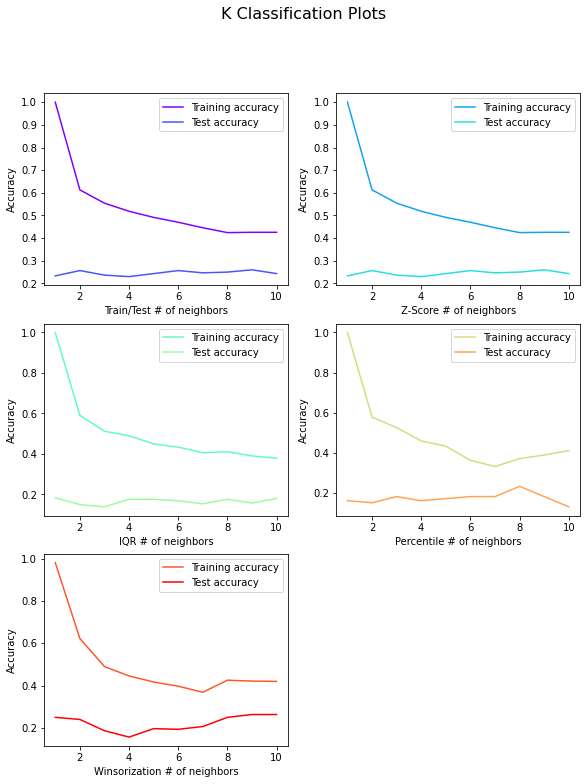

In [ ]:
for name,model in zip(NAMES, MODELS):
  print(name)
  display(print_results(model, name, X_train, y_train, X_test, y_test,
                                     XTrainZ, yTrainZ, XTestZ, yTestZ,
                                     XTrainIQR, yTrainIQR, XTestIQR, yTestIQR,
                                     XTrainPER, yTrainPER, XTestPER, yTestPER,
                                     XTrainWIN, yTrainWIN, XTestWIN, yTestWIN))
  print('\n')

kClassPlot(X_train, y_train, X_test, y_test,
           XTrainZ, yTrainZ, XTestZ, yTestZ,
           XTrainIQR, yTrainIQR, XTestIQR, yTestIQR,
           XTrainPER, yTrainPER, XTestPER, yTestPER,
           XTrainWIN, yTrainWIN, XTestWIN, yTestWIN)

## Dataset 2: California Housing

### 2.1 Loading the Dataset & Detecting NANs

Data has NANs: False


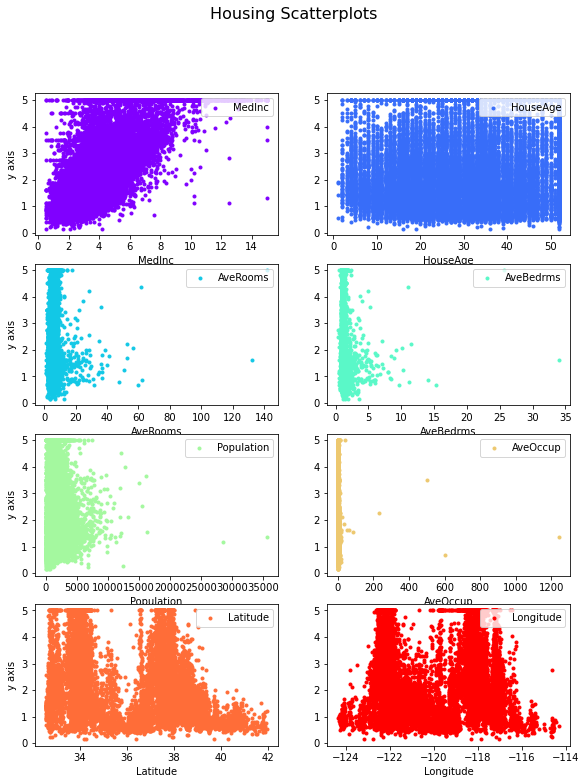

In [ ]:
housing = fetch_california_housing()
X = housing.data
y = housing.target
scatterPlot('Housing Scatterplots')

# Checking for NANs
print('Data has NANs:', pd.isna(housing))

### 2.2 Scaling the data

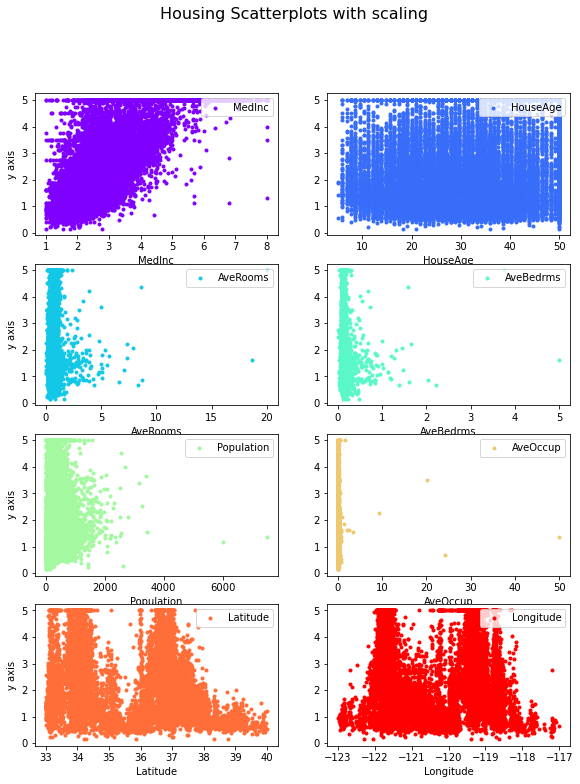

In [ ]:
# Scale MedInc: 1-8 (float)
f1_l, f1_u = float(1), float(8)
X[:,0] = np.interp(X[:,0], (X[:,0].min(), X[:,0].max()), (f1_l, f1_u))

# Scale HouseAge: 5-50 (integer)
f2_l, f2_u = 5, 50
X[:,1] = np.interp(X[:,1], (X[:,1].min(), X[:,1].max()), (f2_l, f2_u))

# Scale AveRooms: 0-20 (integer)
f3_l, f3_u = 0, 20
X[:,2] = np.interp(X[:,2], (X[:,2].min(), X[:,2].max()), (f3_l, f3_u))

# Scale AveBedrms: 0-5 (float)
f4_l, f4_u = float(0), float(5)
X[:,3] = np.interp(X[:,3], (X[:,3].min(), X[:,3].max()), (f4_l, f4_u))

# Scale Population: 0-7500 (float)
f5_l, f5_u = float(0), float(7500)
X[:,4] = np.interp(X[:,4], (X[:,4].min(), X[:,4].max()), (f5_l, f5_u))

# Scale AveOccup: 0-50 (float)
f6_l, f6_u = float(0), float(50)
X[:,5] = np.interp(X[:,5], (X[:,5].min(), X[:,5].max()), (f6_l, f6_u))

# Scale Lattitude: 33-40 (float)
f7_l, f7_u = float(33), float(40)
X[:,6] = np.interp(X[:,6], (X[:,6].min(), X[:,6].max()), (f7_l, f7_u))

# Scale Longitude: -123-(-117) (float)
f8_l, f8_u = float(-123), float(-117)
X[:,7] = np.interp(X[:,7], (X[:,7].min(), X[:,7].max()), (f8_l, f8_u))

scatterPlot('Housing Scatterplots with scaling')

### 2.3 Detect and Remove Outliers

Z-Score: Comparing the distribution of MedInc after capping


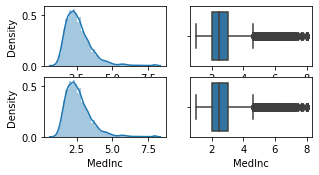

IQR Based Filtering: Comparing the distribution of MedInc after capping


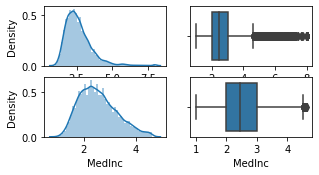

Percentile: Comparing the distribution of MedInc after trimming


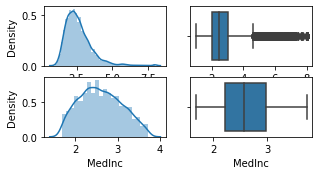

Winsorization: Comparing the distribution of MedInc after capping


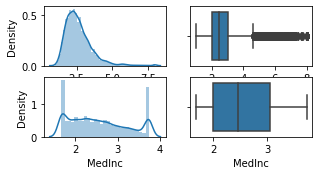

In [ ]:
# Converting y to multiclass (5 classes)
c1, c2, c3, c4 = np.percentile(y, [20, 40, 60, 80])
pos = 0
for i in y:
    if i < c1:
        y[pos] = 0
    elif i < c2:
        y[pos] = 1
    elif i < c3:
        y[pos] = 2
    elif i < c4:
        y[pos] = 3
    else:
        y[pos] = 4
    pos+=1


# Convert to DataFrame
df = pd.DataFrame({housing.feature_names[0]: X[:,0].flatten(),
                   housing.feature_names[1]: X[:,1].flatten(),
                   housing.feature_names[2]: X[:,2].flatten(),
                   housing.feature_names[3]: X[:,3].flatten(),
                   housing.feature_names[4]: X[:,4].flatten(),
                   housing.feature_names[5]: X[:,5].flatten(),
                   housing.feature_names[6]: X[:,6].flatten(),
                   housing.feature_names[7]: X[:,7].flatten(),
                   'y': y})

# Initializing dfs
df_z = df_iqr = df_per = df_win = df.copy()
for i in range(0,8):
    df_z,df_iqr,df_per,df_win = outliers(df.columns[i], df, df_z,df_iqr,df_per,df_win)

# Plotting One Feature
DFLIST = [df_z,df_iqr,df_per,df_win]
DFNAMES = ['Z-Score','IQR Based Filtering','Percentile','Winsorization']
feature = housing.feature_names[0]
for i,name in zip(DFLIST, DFNAMES):
    if name == 'Percentile':
        comparePlot(df,i,feature,name,type1='trimming')
    else:
        comparePlot(df,i,feature,name)

# Converting to numpy
df_z = df_z.to_numpy()
df_iqr = df_iqr.to_numpy()
df_per = df_per.to_numpy()
df_win = df_win.to_numpy()

### 2.4 Apply sampling strategies

In [ ]:
# Training: 70%, Test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainZ, XTestZ, yTrainZ,  yTestZ = train_test_split(df_z[:,0:8], df_z[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainIQR, XTestIQR, yTrainIQR, yTestIQR = train_test_split(df_iqr[:,0:8], df_iqr[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainPER, XTestPER, yTrainPER, yTestPER = train_test_split(df_per[:,0:8], df_per[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)
XTrainWIN, XTestWIN, yTrainWIN, yTestWIN = train_test_split(df_win[:,0:8], df_win[:,-1], test_size=0.3, shuffle=True, random_state = RANDOM_STATE)

### 2.5 Models

Linear Regression


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,-7.38,-7.38,0.64,0.63,0.64
1,Test Accuracy,-40.56,-40.56,0.63,0.63,0.64
2,R²,-40.56,-40.56,0.63,0.63,0.64




Logistic Regression


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.47,0.47,0.45,0.41,0.46
1,Test Accuracy,0.47,0.47,0.45,0.41,0.46
2,R²,0.34,0.34,0.29,0.23,0.31
3,Accuracy,0.47,0.47,0.45,0.41,0.46
4,Weighted F1,0.44,0.44,0.41,0.38,0.43
5,Weighted Precision,0.44,0.44,0.42,0.42,0.43
6,Weighted Recall,0.47,0.47,0.45,0.41,0.46




XGBoost Regressor


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.94,0.94,0.86,0.87,0.94
1,Test Accuracy,0.67,0.67,0.86,0.86,0.67
2,R²,0.73,0.73,0.88,0.89,0.73
3,Accuracy,0.67,0.67,0.86,0.86,0.67
4,Weighted F1,0.67,0.67,0.86,0.86,0.67
5,Weighted Precision,0.67,0.67,0.86,0.86,0.67
6,Weighted Recall,0.67,0.67,0.86,0.86,0.67




K Neighbor Regressor


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.63,0.63,0.46,0.38,0.62
1,Test Accuracy,0.22,0.22,0.48,0.36,0.19
2,R²,0.22,0.22,0.48,0.36,0.19




K Neighbor Classifier


,Score,Train/Test,Z-Score,IQR,Percentile,Winsorization
0,Training Accuracy,0.68,0.68,0.56,0.52,0.67
1,Test Accuracy,0.33,0.33,0.56,0.50,0.32
2,R²,-0.13,-0.13,0.27,-0.00,-0.17
3,Accuracy,0.33,0.33,0.56,0.50,0.32
4,Weighted F1,0.32,0.32,0.54,0.49,0.31
5,Weighted Precision,0.37,0.37,0.60,0.57,0.36
6,Weighted Recall,0.33,0.33,0.56,0.50,0.32


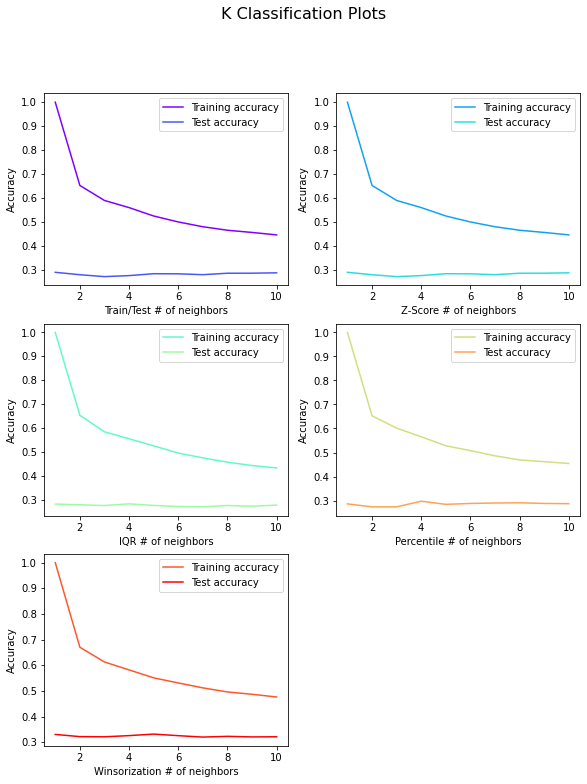

In [ ]:
for name,model in zip(NAMES, MODELS):
  print(name)
  display(print_results(model, name, X_train, y_train, X_test, y_test,
                                     XTrainZ, yTrainZ, XTestZ, yTestZ,
                                     XTrainIQR, yTrainIQR, XTestIQR, yTestIQR,
                                     XTrainPER, yTrainPER, XTestPER, yTestPER,
                                     XTrainWIN, yTrainWIN, XTestWIN, yTestWIN))
  print('\n')

kClassPlot(X_train, y_train, X_test, y_test,
          XTrainZ, yTrainZ, XTestZ, yTestZ,
          XTrainIQR, yTrainIQR, XTestIQR, yTestIQR,
          XTrainPER, yTrainPER, XTestPER, yTestPER,
          XTrainWIN, yTrainWIN, XTestWIN, yTestWIN)

## Summary